# <p style="background-color:Skyblue; font-family:'Orbitron', sans-serif; color:#FFFFFF; font-size:140%; text-align:center; border: 2px solid black; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px;">Tabular Data: Is Attention All You Need?  </p>

https://arxiv.org/pdf/2402.03970

<p align="center">
  <img src="https://i.imgur.com/hSNBNsY.png" />
</p>



## <p style="background-color:Gray; font-family:'Orbitron', sans-serif; color:#FFFFFF; font-size:140%; text-align:center; border: 2px solid black; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px;">ResNeXt??  </p>

<p align="center">
  <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-06_at_4.32.52_PM.png" />
</p>


In [1]:
!pip install scikit-lego

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 6.1 MB/s eta 0:00:00ta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from tensorflow.keras.layers import Dense, Input,Add, Activation,Dropout,BatchNormalization,LayerNormalization, Concatenate, LSTM
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from keras import regularizers

import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklego.preprocessing import RepeatingBasisFunction


In [4]:
import optuna
optimice_NN = False

In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

# Preprocessing

In [7]:
train['Age'] = train['Age'].fillna(16)#bajo el minimo
test['Age'] = test['Age'].fillna(16)


bins_decil_cut_income = pd.qcut(train['Annual Income'], q=10, labels=False, retbins=True)[1]

train['Previous Claims'] = train['Previous Claims'].fillna(-1)
test['Previous Claims'] = test['Previous Claims'].fillna(-1)


medians_train = train[train['Previous Claims'].isin([-1,0, 1, 2])].groupby('Previous Claims')['Annual Income'].median()
median_others_train = train[~train['Previous Claims'].isin([-1, 0, 1, 2])]['Annual Income'].median()

# Función para parchar los nulos usando las medianas del conjunto de entrenamiento
def patch_income(previous_claims, income, medians, median_others):
    if not np.isnan(income):
        return income
    if previous_claims in medians.index:
        return medians[previous_claims]
    else:
        return median_others

# Imputar valores nulos en el conjunto de entrenamiento
train['Annual Income'] = train.apply(
    lambda row: patch_income(row['Previous Claims'], row['Annual Income'], medians_train, median_others_train),
    axis=1
)

# Imputar valores nulos en el conjunto de prueba utilizando las medianas calculadas en el conjunto de entrenamiento
test['Annual Income'] = test.apply(
    lambda row: patch_income(row['Previous Claims'], row['Annual Income'], medians_train, median_others_train),
    axis=1
)

# Dividir 'Annual Income' en deciles dentro del conjunto de entrenamiento
train['Income Decile'] = pd.qcut(train['Annual Income'], q=10, labels=False)

# Calcular medianas del conjunto de entrenamiento
medians_by_decile_train = train[train['Income Decile'] < 8].groupby('Income Decile')['Credit Score'].median()
median_for_deciles_8_9_train = train[train['Income Decile'].isin([8, 9])]['Credit Score'].median()

# Aplicar la misma división de deciles al conjunto de prueba para mantener consistencia
test['Income Decile'] = pd.cut(test['Annual Income'], bins=bins_decil_cut_income, labels=False, include_lowest=True)

# Función para parchar los nulos en ambos conjuntos
def patch_credit_score(decile, credit_score, medians_by_decile, median_8_9):
    if not np.isnan(credit_score):
        return credit_score
    if decile < 8:
        return medians_by_decile[decile]
    else:
        return median_8_9

# Imputación en el conjunto de entrenamiento
train['Credit Score'] = train.apply(
    lambda row: patch_credit_score(row['Income Decile'], row['Credit Score'], medians_by_decile_train, median_for_deciles_8_9_train),
    axis=1
)

# Imputación en el conjunto de prueba
test['Credit Score'] = test.apply(
    lambda row: patch_credit_score(row['Income Decile'], row['Credit Score'], medians_by_decile_train, median_for_deciles_8_9_train),
    axis=1
)

train['Annual Income'] = np.sqrt(train['Annual Income'])
test['Annual Income'] = np.sqrt(test['Annual Income'])

train['Marital Status'] = train['Marital Status'].fillna('Missing')
test['Marital Status'] = test['Marital Status'].fillna('Missing')

train['Number of Dependents'] = train['Number of Dependents'].astype(str).fillna('Missing')
test['Number of Dependents'] = test['Number of Dependents'].astype(str).fillna('Missing')

train['Occupation'] = train['Occupation'].fillna('Missing')
test['Occupation'] = test['Occupation'].fillna('Missing')

# Calcular medianas del conjunto de entrenamiento
medians_by_decile_train = train[train['Income Decile'] < 8].groupby('Income Decile')['Health Score'].median()
median_for_deciles_8_9_train = train[train['Income Decile'].isin([8, 9])]['Health Score'].median()

# Imputación en el conjunto de entrenamiento
train['Health Score'] = train.apply(
    lambda row: patch_credit_score(row['Income Decile'], row['Health Score'], medians_by_decile_train, median_for_deciles_8_9_train),
    axis=1
)

# Imputación en el conjunto de prueba
test['Health Score'] = test.apply(
    lambda row: patch_credit_score(row['Income Decile'], row['Health Score'], medians_by_decile_train, median_for_deciles_8_9_train),
    axis=1
)



train.drop(['Income Decile'],axis=1, inplace = True)
test.drop(['Income Decile'],axis=1, inplace = True)

mean_vehicle_age = train['Vehicle Age'].mean()
train['Vehicle Age'] = train['Vehicle Age'].fillna(mean_vehicle_age)
test['Vehicle Age'] = test['Vehicle Age'].fillna(mean_vehicle_age)

mean_insurance_duration = train['Insurance Duration'].mean()
train['Insurance Duration'] = train['Insurance Duration'].fillna(mean_insurance_duration)
test['Insurance Duration'] = test['Insurance Duration'].fillna(mean_insurance_duration)

train['Customer Feedback'] = train['Customer Feedback'].fillna('Missing')
test['Customer Feedback'] = test['Customer Feedback'].fillna('Missing')

#train.drop(columns =['id'], inplace=True)
#test.drop(columns =['id'], inplace=True)

## feature Engine

In [8]:
def ft_engine(df,rbfTransformer = 0 ,mindate=0):
    #date features
    df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"])
    df["Month"]       = df["Policy Start Date"].dt.month
    df["Day"]         = df["Policy Start Date"].dt.day
    df["Week"]        = df["Policy Start Date"].dt.isocalendar().week
    df["Weekday"]     = df["Policy Start Date"].dt.weekday
    df['DayOfYear']   = df["Policy Start Date"].dt.dayofyear.replace(366, 365)
    #ratios
    df['Ratio Income Age'] = np.clip(df["Annual Income"] / df["Age"], a_min = 1e-6, a_max = 1e9)
    df['Ratio Income Credit'] = np.clip(df["Annual Income"] / df["Credit Score"], a_min = 1e-6, a_max = 1e9)
    df['Ratio Income Health'] = np.clip(df["Annual Income"] / df["Health Score"], a_min = 1e-6, a_max = 1e9)

    #cyclical feat
    df['DaySin']      = np.sin(2 * np.pi * df['Day'] / 30)  
    df['DayCos']      = np.cos(2 * np.pi * df['Day'] / 30)
    df['WeekdaySin']  = np.sin(2 * np.pi * df['Weekday'] / 7)
    df['WeekdayCos']  = np.cos(2 * np.pi * df['Weekday'] / 7)
    if mindate != 0:
        mindate = mindate
    else:
        mindate = min(df['Policy Start Date']) 
    #print(mindate)

    df['TimeEpoch'] = df['Policy Start Date'].astype('int64')/1e9 - mindate.value/1e9 #TODO: analizar si considerar segundos/minutos o solo un epoch de dias

    # Radial basis function para representar comportamiento ciclico del dia del año

    if rbfTransformer != 0:
        rbf = rbfTransformer
    else:
        rbf = RepeatingBasisFunction(n_periods=12,
                             	column="DayOfYear",
                             	input_range=(1,365),
                             	remainder="drop")
        rbf.fit(df)
    
    # Generar RBF transformadas
    X_rbf = pd.DataFrame(index=df.index, data=rbf.transform(df))
    X_rbf.columns = [f"rbf_{i+1}" for i in range(X_rbf.shape[1])]

    df = pd.concat([df, X_rbf], axis=1)
    return df,rbf,mindate

In [9]:
train,rbf,mindate = ft_engine(train)

In [10]:
test,rbf,mindate = ft_engine(test,rbfTransformer=rbf,mindate = mindate)

In [11]:
train.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount', 'Month', 'Day', 'Week', 'Weekday',
       'DayOfYear', 'Ratio Income Age', 'Ratio Income Credit',
       'Ratio Income Health', 'DaySin', 'DayCos', 'WeekdaySin', 'WeekdayCos',
       'TimeEpoch', 'rbf_1', 'rbf_2', 'rbf_3', 'rbf_4', 'rbf_5', 'rbf_6',
       'rbf_7', 'rbf_8', 'rbf_9', 'rbf_10', 'rbf_11', 'rbf_12'],
      dtype='object')

In [12]:

original_columns = ['Age',
 'Gender',
 'Annual Income',
 'Marital Status',
 'Number of Dependents',
 'Education Level',
 'Occupation',
 'Health Score',
 'Location',
 'Policy Type',
 'Previous Claims',
 'Vehicle Age',
 'Credit Score',
 'Insurance Duration',
 #'Policy Start Date',
 'Customer Feedback',
 'Smoking Status',
 'Exercise Frequency',
 'Property Type'
]
target = ['Premium Amount']

In [13]:
date_feat = ['Month', 'Day', 'Week', 'Weekday']
cyclical_feat =  ['DaySin', 'DayCos', 'WeekdaySin', 'WeekdayCos']
feat_epoch =  ['TimeEpoch']
feat_ratios = ['Ratio Income Age',
               'Ratio Income Credit',
               'Ratio Income Health'
              ]

### Pre feat selection

In [14]:
train = train[original_columns + feat_epoch  + target]
test = test[['id']+ original_columns + feat_epoch ]

### feature transform

In [15]:
# all object columns to categorical
for col in train.select_dtypes('object').columns:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [16]:
# Perform One Hot Encoding on the categorical columns
train = pd.get_dummies(train, columns=train.select_dtypes('category').columns, drop_first=True)
test = pd.get_dummies(test, columns=test.select_dtypes('category').columns, drop_first=True)

In [17]:
train.columns

Index(['Age', 'Annual Income', 'Health Score', 'Previous Claims',
       'Vehicle Age', 'Credit Score', 'Insurance Duration', 'TimeEpoch',
       'Premium Amount', 'Gender_Male', 'Marital Status_Married',
       'Marital Status_Missing', 'Marital Status_Single',
       'Number of Dependents_1.0', 'Number of Dependents_2.0',
       'Number of Dependents_3.0', 'Number of Dependents_4.0',
       'Number of Dependents_nan', 'Education Level_High School',
       'Education Level_Master's', 'Education Level_PhD', 'Occupation_Missing',
       'Occupation_Self-Employed', 'Occupation_Unemployed',
       'Location_Suburban', 'Location_Urban', 'Policy Type_Comprehensive',
       'Policy Type_Premium', 'Customer Feedback_Good',
       'Customer Feedback_Missing', 'Customer Feedback_Poor',
       'Smoking Status_Yes', 'Exercise Frequency_Monthly',
       'Exercise Frequency_Rarely', 'Exercise Frequency_Weekly',
       'Property Type_Condo', 'Property Type_House'],
      dtype='object')

In [18]:
test.columns

Index(['id', 'Age', 'Annual Income', 'Health Score', 'Previous Claims',
       'Vehicle Age', 'Credit Score', 'Insurance Duration', 'TimeEpoch',
       'Gender_Male', 'Marital Status_Married', 'Marital Status_Missing',
       'Marital Status_Single', 'Number of Dependents_1.0',
       'Number of Dependents_2.0', 'Number of Dependents_3.0',
       'Number of Dependents_4.0', 'Number of Dependents_nan',
       'Education Level_High School', 'Education Level_Master's',
       'Education Level_PhD', 'Occupation_Missing', 'Occupation_Self-Employed',
       'Occupation_Unemployed', 'Location_Suburban', 'Location_Urban',
       'Policy Type_Comprehensive', 'Policy Type_Premium',
       'Customer Feedback_Good', 'Customer Feedback_Missing',
       'Customer Feedback_Poor', 'Smoking Status_Yes',
       'Exercise Frequency_Monthly', 'Exercise Frequency_Rarely',
       'Exercise Frequency_Weekly', 'Property Type_Condo',
       'Property Type_House'],
      dtype='object')

In [19]:
X2 = train[feat_epoch]
X1 = train.drop(columns=target+feat_epoch, axis=1)
y = np.log1p(train[target])

In [20]:
# Standardize all the data with values from the training set

scaler = StandardScaler()

# Select columns that are not of type bool
non_bool_columns = X1.select_dtypes(exclude='bool').columns

# Scale only the non-bool columns
X1[non_bool_columns] = scaler.fit_transform(X1[non_bool_columns])
test[non_bool_columns] = scaler.transform(test[non_bool_columns])

In [21]:
X_train, X_val,X_train_time,X_val_time, y_train, y_val = train_test_split(X1,X2, y, test_size=0.1, random_state=42)

In [22]:
time_max = X_train_time.max()
time_min = X_train_time.min()

In [23]:
X_train_time = (X_train_time-time_min)/(time_max-time_min)
X_val_time = (X_val_time-time_min)/(time_max-time_min)

## Baseline model

In [24]:
def rmsle(y_true, y_pred):
    y_pred = tf.maximum(y_pred, 0)

    log_true = tf.math.log1p(y_true)
    log_pred = tf.math.log1p(y_pred)

    squared_diff = tf.square(log_true - log_pred)
    mean_squared_log_error = tf.reduce_mean(squared_diff)
    return tf.sqrt(mean_squared_log_error)

# Definir una métrica personalizada para RMSE
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [25]:
model1 = Sequential([
    Dense(256, activation='relu'), 
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    Dense(1)
])

model1.compile(optimizer='adam', loss='mse',metrics =[rmse])

In [26]:
history_model1 = model1.fit(X_train
                            , y_train
                            , epochs= 15
                            , batch_size=512
                            , validation_data=(X_val, y_val)
                            , validation_batch_size = 2**int(np.ceil(np.log2(len(y_val))))
                           )

Epoch 1/15
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 2.5032 - rmse: 1.3512 - val_loss: 1.1983 - val_rmse: 1.0915
Epoch 2/15
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.1940 - rmse: 1.0890 - val_loss: 1.1808 - val_rmse: 1.0849
Epoch 3/15
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.1792 - rmse: 1.0833 - val_loss: 1.1804 - val_rmse: 1.0852
Epoch 4/15
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.1762 - rmse: 1.0823 - val_loss: 1.1691 - val_rmse: 1.0802
Epoch 5/15
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.1629 - rmse: 1.0763 - val_loss: 1.1627 - val_rmse: 1.0773
Epoch 6/15
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.1608 - rmse: 1.0753 - val_loss: 1.1579 - val_rmse: 1.0751
Epoch 7/15
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.1569 - rmse: 1.0737 - val_loss: 1.1569 - val_rmse: 1.0747
Epoch 8/15
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.1530 - rmse: 1.0718 - val_loss: 1.1637 - val_rmse: 1.0780
Epoch 9/15
2110/2110 ━━━

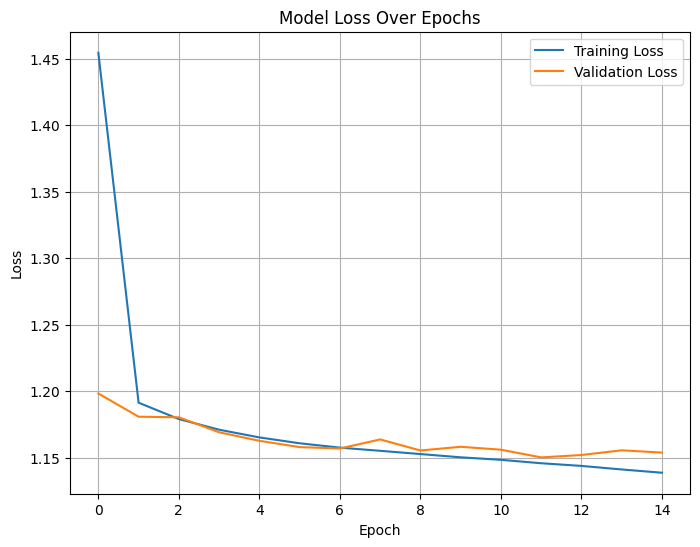

In [27]:

plt.figure(figsize=(8, 6))
plt.plot(history_model1.history['loss'], label='Training Loss')
plt.plot(history_model1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [28]:
print(model1.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,445 (615.02 KB)

 Trainable params: 52,481 (205.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 104,964 (410.02 KB)

None


## Modelo residual

In [29]:
es = EarlyStopping(patience=25
                   , verbose=0
                   , min_delta=0.00005
                   , monitor='val_y_amount_layer_rmse'
                   , mode='min'
                   , restore_best_weights=True)

#Learning rate decay
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.975#ops.exp(-0.1)

lr_sc = keras.callbacks.LearningRateScheduler(scheduler, verbose=0)


# Preparar otras características para el modelo
other_features = X1.values

def residual_block(x, units):
    # Primer bloque denso en la red residual
    residual = Dense(units, activation='relu')(x)
    #residual = Dense(units)(residual)  # Segundo bloque denso
    x = Add()([x, residual])  # Conexión residual: se suma a la entrada
    x = Activation('relu')(x)  # Activación después de la suma
    return x


def residual_block_resNeXt(x_in, units, N_parallel,factor = 0, dropout_rate=0.2):
    # Crear la lista que almacenará las salidas de los bloques paralelos
    parallel_residuals = []
    
    # Primer bloque denso común para todos los caminos paralelos
    x1 = Dense(units, activation='elu')(x_in)

    # Crear los bloques paralelos
    for i in range(N_parallel):
        if factor > 0:
            residual_out = Dense(units, activation='elu')(x1)  # Bloques paralelos
            residual_out = Dense(int(units*factor), activation='elu')(residual_out)  # Bloques paralelos
        else:
            residual_out = Dense(units, activation='elu')(x1)  # Bloques paralelos

        parallel_residuals.append(residual_out)
    if len(parallel_residuals) == 1:
    # Solo un camino, no usar Concatenate
        x = parallel_residuals[0]
    else:
        # Sumar todas las salidas paralelas
        x = Add()(parallel_residuals)

    # Crear el residual de la suma de los paralelos
    residual = Dense(units, activation='elu')(x)
    
    # Aplicar Dropout
    if dropout_rate > 0:
        residual = Dropout(dropout_rate)(residual)

    # Sumar la entrada x1 con el residual procesado
    x = Add()([x1, residual])

    # Aplicar activación final
    x = Activation('elu')(x)
    
    return x
    
def make_normalization():
    if normalization == 'batchnorm':
        return BatchNormalization()
    elif normalization == 'layernorm':
        return LayerNormalization()
    else:
        raise ValueError("Normalization method not supported.")


# Definir la subred para datos temporales utilizando Time2Vec
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, kernel_size=1, **kwargs):
        super(Time2Vec, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.wb = self.add_weight(shape=(input_shape[-1], self.kernel_size), initializer='uniform', trainable=True)
        self.bb = self.add_weight(shape=(self.kernel_size,), initializer='uniform', trainable=True)
        self.wa = self.add_weight(shape=(input_shape[-1], self.kernel_size), initializer='uniform', trainable=True)
        self.ba = self.add_weight(shape=(self.kernel_size,), initializer='uniform', trainable=True)

    def call(self, inputs):
        bias = tf.matmul(inputs, self.wb) + self.bb
        wgts = tf.matmul(inputs, self.wa) + self.ba
        wgts = tf.math.sin(wgts)
        return tf.concat([bias, wgts], axis=-1)

def create_model(N_features
                 , kernel_t2v
                 , process_temporal_1_units
                 , process_temporal_2_units
                 , process_features_1_units
                 , process_features_2_units
                 , first_residual_units
                 , first_residual_parallel
                 , first_residual_factor
                 , backbone_classfier_units
                 , backbone_1_units
                 , backbone_1_parallel
                 , backbone_1_factor
                 , backbone_1_cardinality
                 , backbone_2_units
                 , backbone_2_parallel
                 , backbone_2_factor
                 , backbone_2_cardinality
                 , backbone_regressor_units
                 , residual_dropout
                 , lr = 0.001
                ):
    # Subred temporal usando Time2Vec
    input_time = Input(shape=(1,))
    encoded_time = Time2Vec(kernel_size=kernel_t2v)(input_time)
    temporal_branch = Dense(process_temporal_1_units, activation='elu')(encoded_time)

    if process_temporal_2_units >0 :
        temporal_branch = Dense(process_temporal_2_units, activation='elu')(temporal_branch)

    # Subred para otras características
    input_features = Input(shape=(N_features,))
    feature_branch = Dense(process_features_1_units, activation='elu')(input_features)

    if process_features_2_units >0 :
        feature_branch = Dense(process_features_2_units, activation='elu')(feature_branch)

    # Concatenar ambas subredes
    combined = Concatenate()([temporal_branch, feature_branch])

    # fisrt residual block
    if first_residual_units >0:
        x = residual_block_resNeXt(combined
                                   , units = first_residual_units
                                   , N_parallel = first_residual_parallel
                                   , factor = first_residual_factor
                                   , dropout_rate = residual_dropout
                                  )
    else:
        x = combined
    #backbone classfier
    y = Dense(backbone_classfier_units, activation = 'elu')(x)
    output_2 = Dense(1,activation = 'sigmoid' ,name='y_class_layer')(y)

    #backbone regression
    if backbone_1_units > 0:
        for _ in range(backbone_1_cardinality):
            x = residual_block_resNeXt(x
                                       , units = backbone_1_units
                                       , factor=backbone_1_factor
                                       , N_parallel = backbone_1_parallel
                                       , dropout_rate = residual_dropout
                                      )
        
    x = Concatenate()([x,output_2])
    
    if backbone_2_units > 0:
        for _ in range(backbone_2_cardinality):
            x = residual_block_resNeXt(x
                                       , units = backbone_2_units
                                       , factor=backbone_2_factor
                                       , N_parallel = backbone_2_parallel
                                       , dropout_rate = residual_dropout
                                      )

    x = Dense(backbone_regressor_units,activation = 'elu')(x)

    #x = make_normalization()(x)

    output = Dense(1,name='y_amount_layer')(x)

    # Crear el modelo completo
    model = Model(inputs=[input_time, input_features], outputs=[output,output_2])

    opt = Adam(learning_rate=lr)

    model.compile(optimizer= opt
                  ,loss = {'y_amount_layer' : 'mse'
                            ,'y_class_layer' : 'binary_crossentropy'
                          }
                  , metrics = {
                             'y_amount_layer': rmse
                              ,'y_class_layer': 'accuracy'
                           })


    return model



In [30]:
def optuna_objective(trial:optuna.Trial) -> float:
    config = {
    "N_features": other_features.shape[1],
    "kernel_t2v": trial.suggest_categorical('kernel_t2v', choices = [8,16]),
    "process_temporal_1_units": trial.suggest_categorical('process_temporal_1_units', choices = [8,16,20,32,40]),
    "process_temporal_2_units": trial.suggest_categorical('process_temporal_2_units', choices = [8,16,20,32,40]),
    "process_features_1_units": trial.suggest_categorical('process_features_1_units', choices = [16,20,32,40,64]),
    "process_features_2_units": trial.suggest_categorical('process_features_2_units', choices = [0,16,20,32,40,64]),
    "first_residual_units": trial.suggest_categorical('first_residual_units', choices = [0,8,16,20,32,40,64]),
    "first_residual_parallel": trial.suggest_categorical('first_residual_parallel', choices = [1,2,3,4,8,16]),
    "first_residual_factor": trial.suggest_categorical('first_residual_factor', choices = [0,0.25,0.5,1,1.5,2,4]),
    "backbone_classfier_units": trial.suggest_categorical('backbone_classfier_units', choices = [8,16,20,32,64]),
    "backbone_1_units":  trial.suggest_categorical('backbone_1_units', choices = [0,8,16,20,32,40,64]),
    "backbone_1_parallel": trial.suggest_categorical('backbone_1_parallel', choices = [1,2,3,4,8,16]),
    "backbone_1_factor": trial.suggest_categorical('backbone_1_factor', choices = [0,0.25,0.5,1,1.5,2,4]),
    "backbone_1_cardinality": trial.suggest_categorical('backbone_1_cardinality', choices = [0,1,2,3,4,8]),
    "backbone_2_units": trial.suggest_categorical('backbone_2_units', choices = [8,16,20,32,40,64]),
    "backbone_2_parallel": trial.suggest_categorical('backbone_2_parallel', choices = [1,2,3,4,8,16]),
    "backbone_2_factor": trial.suggest_categorical('backbone_2_factor', choices = [0,0.25,0.5,1,1.5,2,4]),
    "backbone_2_cardinality": trial.suggest_categorical('backbone_2_cardinality', choices = [1,2,3,4,8]),
    "backbone_regressor_units": trial.suggest_categorical('backbone_regressor_units', choices = [8,16,20,32,40,64]),
    "residual_dropout":trial.suggest_categorical('residual_dropout', choices = [0,0.1,0.2,0.25,0.3,0.4,0.5]),
    "lr":trial.suggest_float('lr', 0.001, 0.01, step=0.0005)

    }
    
    EPOCHS = 300
    BATCH_SIZE = trial.suggest_categorical('batch_size', choices = [8192])
    model = create_model(**config)
    total_params = sum(layer.count_params() for layer in model.layers if hasattr(layer, 'count_params'))

    if total_params > 100000: #supera cantidad de parametros
        return 1.2
    
    history = model.fit(
        [X_train_time.values.reshape(-1, 1), X_train]
        , [y_train,(y_train>7.316) | (y_train<6.244)]
        , validation_data =([X_val_time.values.reshape(-1, 1), X_val],[y_val,(y_val>7.316) | (y_val<6.244)  ] )
        , epochs=EPOCHS
        , batch_size = BATCH_SIZE
        , callbacks=[es,lr_sc]
        , shuffle = True
        , validation_steps = None
        , validation_batch_size = 2**int(np.ceil(np.log2(len(y_val))))
        , verbose = 0
    )
    return model.evaluate([X_val_time.values.reshape(-1, 1), X_val], [y_val,(y_val>7.316) | (y_val<6.244) ],batch_size =2**int(np.ceil(np.log2(len(y_val)))))[1]

In [31]:
sampler = optuna.samplers.TPESampler(
    n_startup_trials=25, seed=1234
)

study = optuna.create_study(
    directions=['minimize'], sampler=sampler,study_name='resnext_time2vec'
)

[I 2024-12-20 13:22:25,607] A new study created in memory with name: resnext_time2vec


In [32]:
# adding best trials from previous version
study.enqueue_trial(params={'kernel_t2v': 8
                            , 'process_temporal_1_units': 16
                            , 'process_temporal_2_units': 8
                            , 'process_features_1_units': 64
                            , 'process_features_2_units': 64
                            , 'first_residual_units': 32
                            , 'first_residual_parallel': 8
                            , 'first_residual_factor': 0
                            , 'backbone_classfier_units': 32
                            , 'backbone_1_units': 0
                            , 'backbone_1_parallel': 4
                            , 'backbone_1_factor': 0
                            , 'backbone_1_cardinality': 1
                            , 'backbone_2_units': 16
                            , 'backbone_2_parallel': 8
                            , 'backbone_2_factor': 0
                            , 'backbone_2_cardinality': 2
                            , 'backbone_regressor_units': 32
                            , 'batch_size': 8192
                            , 'residual_dropout': 0.2
                            , "lr":0.0075

                           })

study.enqueue_trial(params={ 'kernel_t2v': 16
                            , 'process_temporal_1_units': 16
                            , 'process_temporal_2_units': 8
                            , 'process_features_1_units': 64
                            , 'process_features_2_units': 64
                            , 'first_residual_units': 32
                            , 'first_residual_parallel': 8
                            , 'first_residual_factor': 0
                            , 'backbone_classfier_units': 32
                            , 'backbone_1_units': 0
                            , 'backbone_1_parallel': 4
                            , 'backbone_1_factor': 0
                            , 'backbone_1_cardinality': 1
                            , 'backbone_2_units': 16
                            , 'backbone_2_parallel': 8
                            , 'backbone_2_factor': 0
                            , 'backbone_2_cardinality': 2
                            , 'backbone_regressor_units': 32
                            , 'batch_size': 8192
                            , 'residual_dropout': 0.2
                            , "lr":0.0075
                           })

study.enqueue_trial( params = {'kernel_t2v': 16
                             , 'process_temporal_1_units': 32
                             , 'process_temporal_2_units': 40
                             , 'process_features_1_units': 16
                             , 'process_features_2_units': 20
                             , 'first_residual_units': 40
                             , 'first_residual_parallel': 2
                             , 'first_residual_factor': 1
                             , 'backbone_classfier_units': 64
                             , 'backbone_1_units': 64
                             , 'backbone_1_parallel': 4
                             , 'backbone_1_factor': 0.5
                             , 'backbone_1_cardinality': 0
                             , 'backbone_2_units': 8
                             , 'backbone_2_parallel': 1
                             , 'backbone_2_factor': 1.5
                             , 'backbone_2_cardinality': 4
                             , 'backbone_regressor_units': 64
                             , 'residual_dropout': 0.4
                             , 'lr': 0.0095
                             , 'batch_size': 8192
                              })


In [33]:
# run optuna for a maxmimum of 100 trials and 4hr wall clock time
if optimice_NN:
    study.optimize(optuna_objective, n_trials=3, timeout=3600*4) 

In [34]:
params = {"N_features": other_features.shape[1]
    ,'kernel_t2v': 16
    , 'process_temporal_1_units': 16
    , 'process_temporal_2_units': 8
    , 'process_features_1_units': 64
    , 'process_features_2_units': 64
    , 'first_residual_units': 32
    , 'first_residual_parallel': 8
    , 'first_residual_factor': 0
    , 'backbone_classfier_units': 32
    , 'backbone_1_units': 0
    , 'backbone_1_parallel': 4
    , 'backbone_1_factor': 0
    , 'backbone_1_cardinality': 1
    , 'backbone_2_units': 16
    , 'backbone_2_parallel': 8
    , 'backbone_2_factor': 0
    , 'backbone_2_cardinality': 2
    , 'backbone_regressor_units': 32
    #, 'batch_size': 256
    , 'residual_dropout': 0.2
    , "lr":0.0075
   }

In [35]:
model = create_model(**params)
total_params = sum(layer.count_params() for layer in model.layers if hasattr(layer, 'count_params'))
print(total_params)

26410


In [36]:
history = model.fit(
    [X_train_time.values.reshape(-1, 1), X_train]
    , [y_train,(y_train>7.316) | (y_train<6.244)]
    , validation_data =([X_val_time.values.reshape(-1, 1), X_val],[y_val,(y_val>7.316) | (y_val<6.244)  ] )
    , epochs=300
    , batch_size = 8192
    , callbacks=[es,lr_sc]
    , shuffle = True
    , validation_steps = None
    , validation_batch_size = 2**int(np.ceil(np.log2(len(y_val))))
    , verbose = 1
)

Epoch 1/300
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 8.6937 - y_amount_layer_rmse: 2.0876 - y_class_layer_accuracy: 0.5064 - val_loss: 1.9106 - val_y_amount_layer_rmse: 1.1021 - val_y_class_layer_accuracy: 0.5009 - learning_rate: 0.0075
Epoch 2/300
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9130 - y_amount_layer_rmse: 1.1060 - y_class_layer_accuracy: 0.5283 - val_loss: 1.8754 - val_y_amount_layer_rmse: 1.0943 - val_y_class_layer_accuracy: 0.5591 - learning_rate: 0.0075
Epoch 3/300
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8870 - y_amount_layer_rmse: 1.0995 - y_class_layer_accuracy: 0.5530 - val_loss: 1.8572 - val_y_amount_layer_rmse: 1.0890 - val_y_class_layer_accuracy: 0.5635 - learning_rate: 0.0075
Epoch 4/300
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8663 - y_amount_layer_rmse: 1.0928 - y_class_layer_accuracy: 0.5595 - val_loss: 1.8440 - val_y_amount_layer_rmse: 1.0856 - val_y_class_layer_accuracy: 0.5684 - learning_rate: 0.0075
Epoch 5/300
132/13

In [37]:
model.evaluate([X_val_time.values.reshape(-1, 1), X_val], [y_val,(y_val>7.316) | (y_val<6.244) ],batch_size =2**int(np.ceil(np.log2(len(y_val)))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.6848 - y_amount_layer_rmse: 1.0507 - y_class_layer_accuracy: 0.6524


[1.6847963333129883, 1.0507432222366333, 0.65235835313797]

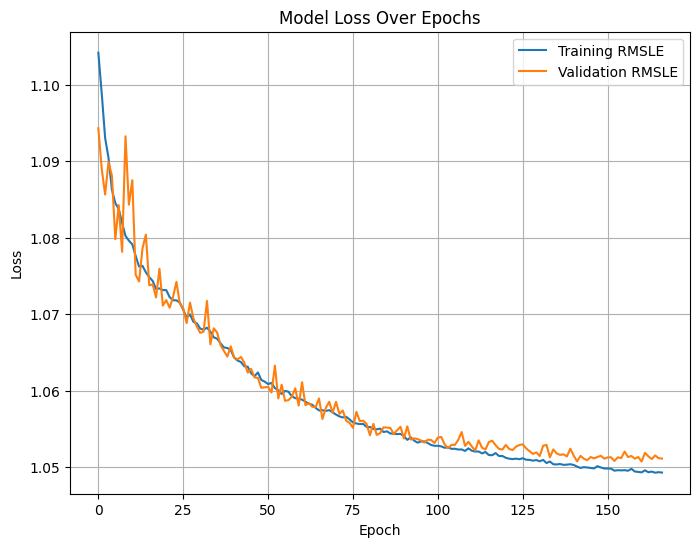

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['y_amount_layer_rmse'][1:], label='Training RMSLE')
plt.plot(history.history['val_y_amount_layer_rmse'][1:], label='Validation RMSLE')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [39]:
keras.utils.plot_model(model, 'model_resnext_test.png', show_shapes=True)


In [40]:
test.columns

Index(['id', 'Age', 'Annual Income', 'Health Score', 'Previous Claims',
       'Vehicle Age', 'Credit Score', 'Insurance Duration', 'TimeEpoch',
       'Gender_Male', 'Marital Status_Married', 'Marital Status_Missing',
       'Marital Status_Single', 'Number of Dependents_1.0',
       'Number of Dependents_2.0', 'Number of Dependents_3.0',
       'Number of Dependents_4.0', 'Number of Dependents_nan',
       'Education Level_High School', 'Education Level_Master's',
       'Education Level_PhD', 'Occupation_Missing', 'Occupation_Self-Employed',
       'Occupation_Unemployed', 'Location_Suburban', 'Location_Urban',
       'Policy Type_Comprehensive', 'Policy Type_Premium',
       'Customer Feedback_Good', 'Customer Feedback_Missing',
       'Customer Feedback_Poor', 'Smoking Status_Yes',
       'Exercise Frequency_Monthly', 'Exercise Frequency_Rarely',
       'Exercise Frequency_Weekly', 'Property Type_Condo',
       'Property Type_House'],
      dtype='object')

In [41]:
X2_test = test[feat_epoch]
X1_test = test.drop(columns=feat_epoch+['id'], axis=1)

In [42]:
X2_test = (X2_test-time_min)/(time_max-time_min)

In [43]:
preds = model.predict([X2_test,X1_test])

25000/25000 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step


In [44]:
test[target] = np.expm1(preds[0])

In [45]:
test.head()

,id,Age,Annual Income,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,TimeEpoch,Gender_Male,...,Customer Feedback_Good,Customer Feedback_Missing,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House,Premium Amount
0,1200000,-0.924819,-1.314516,-1.513268,-1.131422,1.632588,-0.005051,-1.548847,1.198368e+08,False,...,False,False,True,True,False,False,True,False,True,806.786865
1,1200001,-0.707276,2.321501,-1.029206,-1.131422,0.766963,-1.559674,1.149346,1.477440e+08,False,...,True,False,False,True,False,True,False,False,False,782.832642
2,1200002,0.452953,-0.335178,-0.101142,-1.131422,1.113213,1.584744,1.534802,1.146528e+08,False,...,False,False,False,True,True,False,False,True,False,811.823364
3,1200003,-0.924819,0.182345,-1.726548,0.490504,-1.137412,1.240054,-0.007023,1.321920e+08,False,...,False,False,True,True,False,False,False,False,True,807.476257
4,1200004,-1.214876,-0.649218,-1.159218,-1.131422,0.766963,1.134537,0.763889,7.188480e+07,True,...,False,False,False,False,False,False,True,False,True,779.722778


array([[<Axes: title={'center': 'Premium Amount'}>]], dtype=object)

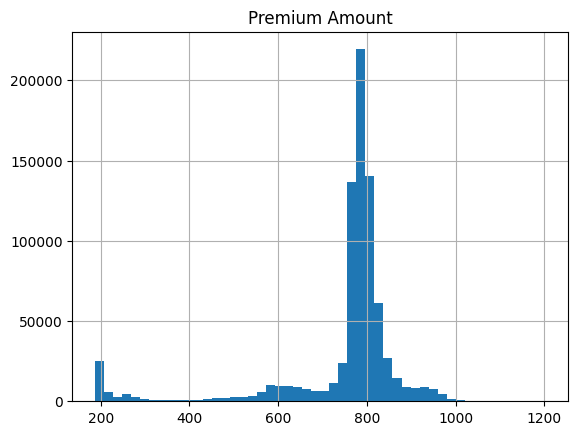

In [46]:
test[target].hist(bins=50)

In [47]:
df_submission = test[['id','Premium Amount']].copy()


In [48]:
df_submission.to_csv('submission.csv', index=False)
